# Statistics Group 12 - Final Project

### Data Structure
A dataset containing 1311 entries on 6 variables, for 57 countries over 23 years. The variables are as follows:

- **Year**: The year of observation
- **GDP Growth**: Annual GDP growth rate
- **GFCF change**: Gross Fixed Capital Formation change
- **Inflation change**: Percentage change in inflation
- **Net Trade change**: Percentage change in net trade
- **Unemployment change**: Percentage change in unemployment (some entries may have null values)

### Objective 
Predict the GDP growth rate with the other variables as predictors.

In [59]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

# Import OLS 
import statsmodels.api as sm

# Import data
data = pd.read_csv('../Data/economic_indicators.csv', index_col=0)

#### Check correlations

In [60]:
data_explore = data.drop('Year', axis=1)
data_explore.corr()

,GDP Growth,GFCF change,Inflation change,Unemployment change
GDP Growth,1.000000,0.583332,-0.086875,-0.386171
GFCF change,0.583332,1.000000,0.135399,-0.346725
Inflation change,-0.086875,0.135399,1.000000,-0.047444
Unemployment change,-0.386171,-0.346725,-0.047444,1.000000


#### Check VIF

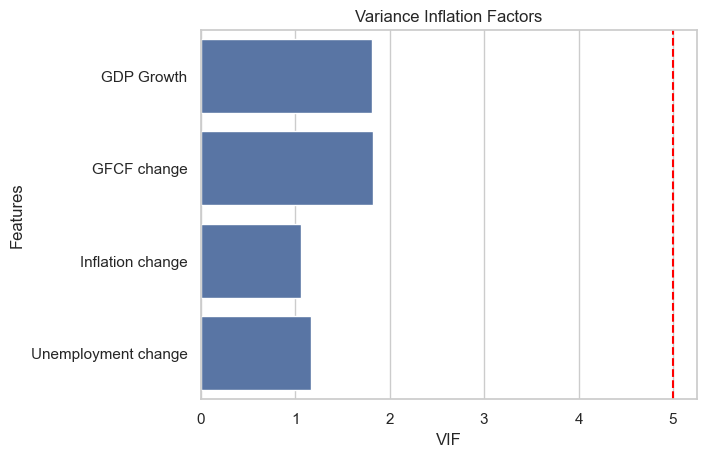

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate the VIF with confidence intervals
variables = data_explore
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif.round(1)

# Plot the VIF
sns.set(style="whitegrid")
ax = sns.barplot(x="VIF", y="Features", data=vif)
# Add a line on 5
plt.axvline(x=5, color='red', linestyle='--')
plt.title('Variance Inflation Factors')
plt.show()

#### Check for interactions with the target variable

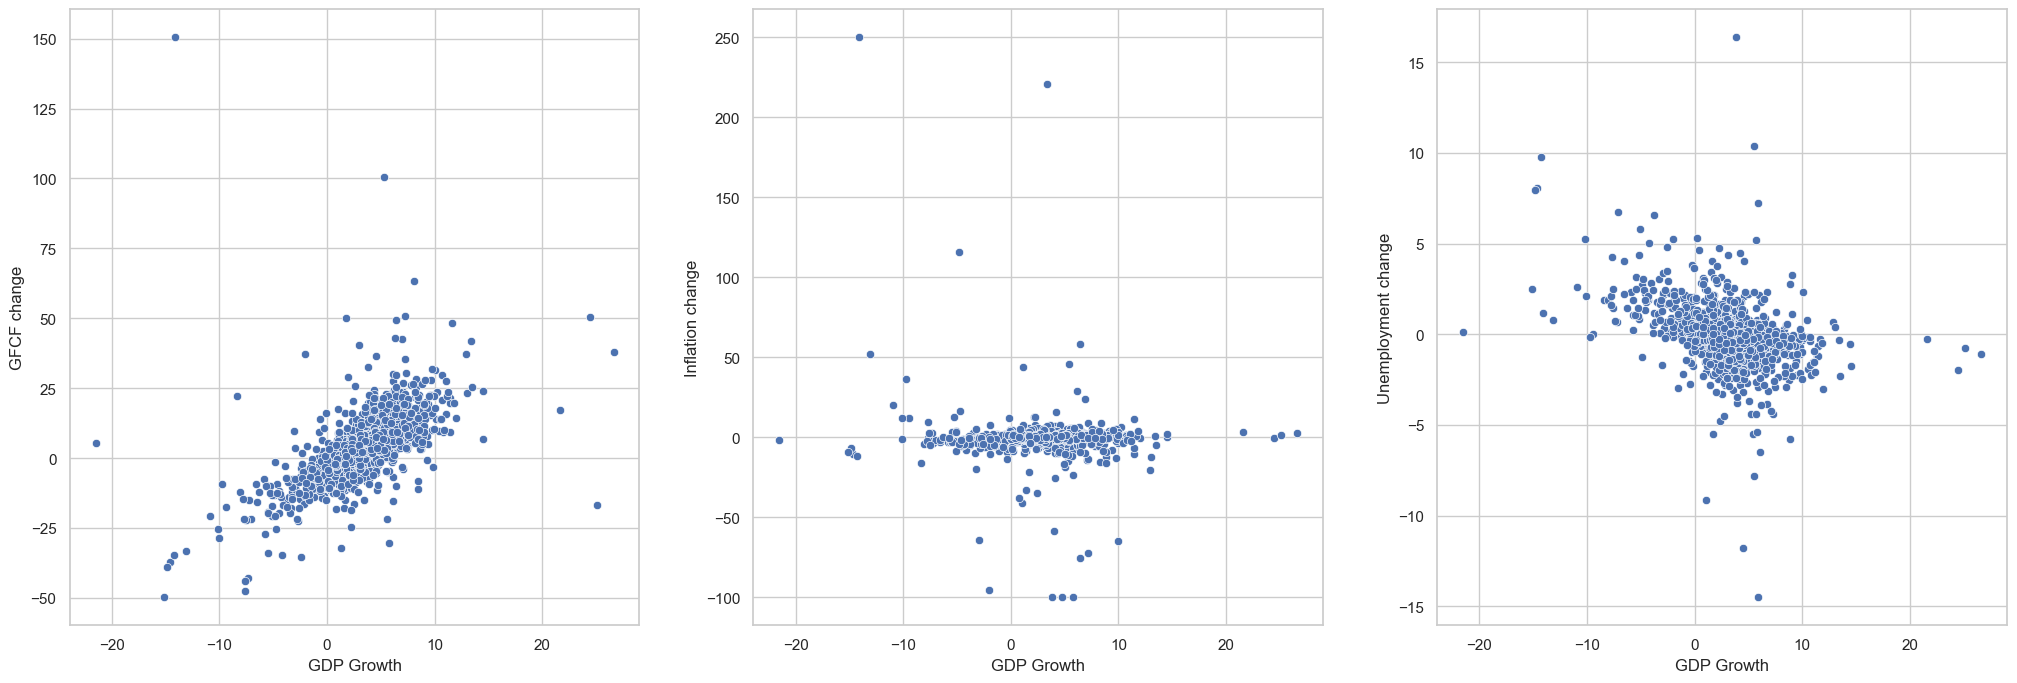

In [73]:
# Plot scatterplots of the variables against the GDP Growth
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25,8))
sns.scatterplot(x="GDP Growth", y="GFCF change", data=data, ax=axs[0])
sns.scatterplot(x="GDP Growth", y="Inflation change", data=data, ax=axs[1])
sns.scatterplot(x="GDP Growth", y="Unemployment change", data=data, ax=axs[2])
plt.show()

In [75]:
X = data.drop(['GDP Growth', 'Year'], axis=1)
y = data['GDP Growth']

# Add constant to X
X = sm.add_constant(X)

# Fit OLS
pooled_ols = sm.OLS(y, X).fit() 

# Print summary table
print(pooled_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP Growth   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     340.8
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          1.68e-168
Time:                        23:53:20   Log-Likelihood:                -3638.0
No. Observations:                1495   AIC:                             7284.
Df Residuals:                    1491   BIC:                             7305.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.3152    

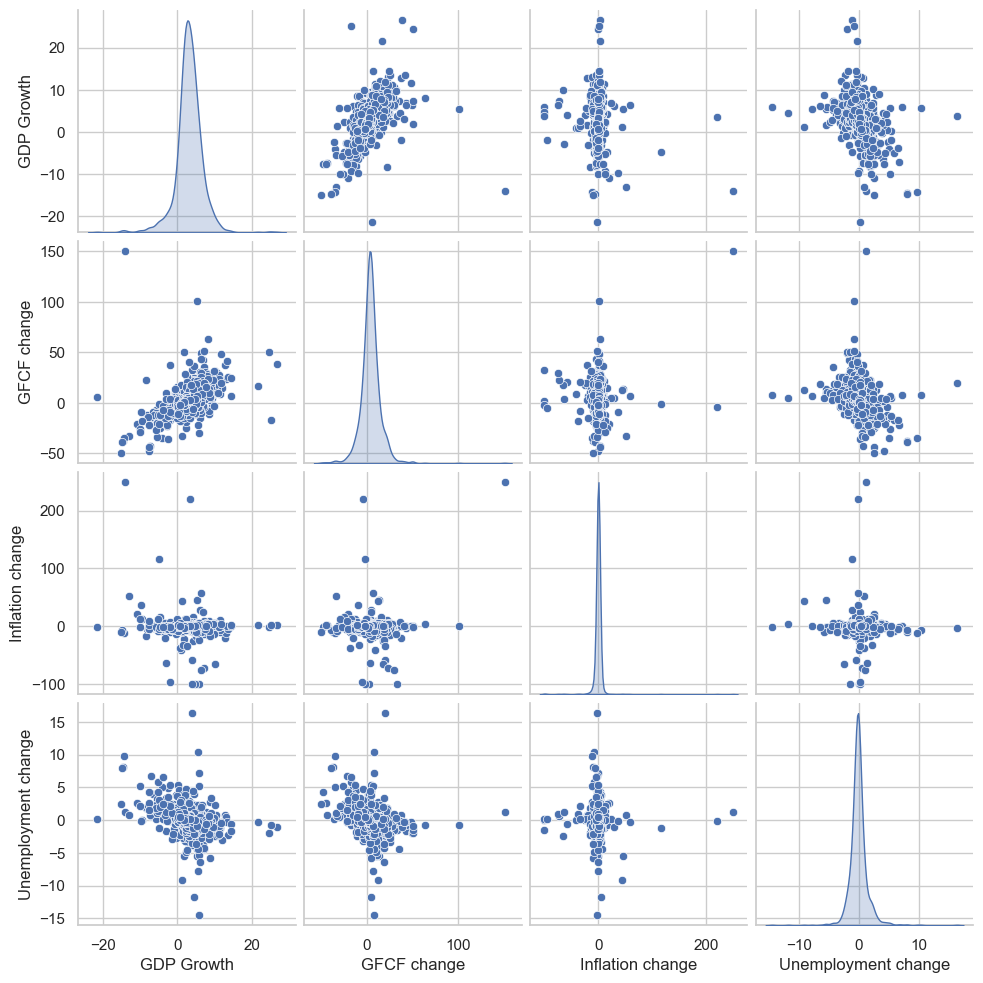

In [77]:
# Plot all the scatter and distribution plots
sns.pairplot(data_explore, diag_kind='kde')
plt.show()